<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Coffee & Tea Subreddits Analysis - NLP

Note: This is part 3 of the code notebook covering the following:-
1. [Library Imports & Functions Creation](#1.-Library-Imports-&-Functions-Creation)
2. [Datasets Recap](#2.-Datasets-Recap)
3. [Baseline Sentiment Analysis: TextBlob](#3.-Baseline-Sentiment-Analysis:-TextBlob)
4. [Sentiment Analysis: Pysentimiento](#4.-Sentiment-Analysis:-Pysentimiento)
5. [Emotion Analysis: Pysentimiento](#5.-Emotion-Analysis:-Pysentimiento)
6. [Analysis based on Popular Topics: Pysentimiento](#6.-Analysis-based-on-Popular-Topics:-Pysentimiento)
7. [Summary of Notebook 3](#7.-Summary-of-Notebook-3)
8. [Conclusion](#8.-Conclusion)

## 1. Library Imports & Functions Creation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from pysentimiento import create_analyzer
from spacytextblob.spacytextblob import SpacyTextBlob
from transformers import pipeline
from spacy.language import Language
from textblob import TextBlob

In [2]:
def blob_sent_pred(x):
    blob = TextBlob(x)
    if blob.sentiment_assessments.polarity < 0:
        return 0
    else:
        return 1

In [3]:
def blob_sub_pred(x):
    blob = TextBlob(x)
    if blob.sentiment_assessments.subjectivity < 0.5:
        return 0
    else:
        return 1

In [4]:
def graph_for_sent_emo(i, j, label1, label2, ylabel, title):
    plt.figure(figsize=(8,4))
    X = ['Positive', 'Joy']
    first = [i['POS'].mean(),i['joy'].mean()]
    second = [j['POS'].mean(),j['joy'].mean()]
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, first, 0.4, label = label1, color = 'tab:green')
    plt.bar(X_axis + 0.2, second, 0.4, label = label2, color = 'silver')
    plt.xticks(X_axis, X, size = 14)
    plt.ylabel(ylabel, size = 14)
    plt.title(title, size = 18)
    plt.legend()
    plt.show();

## 2. Datasets Recap

In [5]:
# Importing datasets
coffee_df = pd.read_csv('coffee_df_cleaned.csv')
tea_df = pd.read_csv('tea_df_cleaned.csv')

In [6]:
# Recap on the data
coffee_df.head()

,subreddit,author,date_posted,text,text_cleaned
0,Coffee,_FormerFarmer,2022-09-30,Coffee reduces cardiovascular disease - large ...,coffee reduces cardiovascular disease large po...
1,Coffee,Geegoriel9,2022-09-30,"Where do Europeans get their coffee, Stareuros? -",europeans get coffee stareuros
2,Coffee,TheRealOsamaru,2022-09-30,Dark and Stormy Coffee; why am I just learning...,dark stormy coffee learning 12oz black coffee ...
3,Coffee,Complex_Secretary_14,2022-09-30,Should I learn how to roast coffee beans befor...,learn roast coffee beans learning particular b...
4,Coffee,deemonstalker,2022-09-30,Roast me! -,roast


In [7]:
tea_df.head()

,subreddit,author,date_posted,text,text_cleaned
0,tea,psydchicjohn,2022-09-30,Can someone recommend a tea for me? My lovely ...,someone recommend tea lovely wife drinking slo...
1,tea,piecesofagrippa,2022-09-30,Buying Chamomile in US I took a look at the ve...,buying chamomile us took look vendors list non...
2,tea,SamGoldfield,2022-09-30,Is this a good introduction to kamairicha? -,introduction kamairicha
3,tea,yddandy,2022-09-30,I was curious about the story on Colombian bla...,curious colombian black tea found answers alth...
4,tea,Lucre_15,2022-09-30,Haul! Any suggestions on how to brew these tea...,haul suggestions brew teas


## 3. Baseline Sentiment Analysis: TextBlob

We shall first apply sentiment analysis using [Textblob](https://textblob.readthedocs.io/en/dev/), which is a Python library processing textual data.

The analysis is on two areas:-
 - Sentiment: The higher the polarity score the more positive a post is. The range of the score is from -1 to 1. Polarity score above 0 is classified as positive indicated as 1, while score below 0 is classified as negative indicated as 0. 
 - Subjectivity: The higher the subjectivity score the more subjective a post is. The range of the score is from 0 to 1. Subjectivity score below 0.5 is classifed as objective indicated as 0, score 0.5 or more is classified as subjective indicated as 1.  

In [8]:
# Applying sentiment analysis
coffee_df['sent_pred'] = coffee_df['text'].apply(blob_sent_pred)
tea_df['sent_pred'] = tea_df['text'].apply(blob_sent_pred)

In [9]:
# Applying subjectivity analysis
coffee_df['sub_pred'] = coffee_df['text'].apply(blob_sub_pred)
tea_df['sub_pred'] = tea_df['text'].apply(blob_sub_pred)

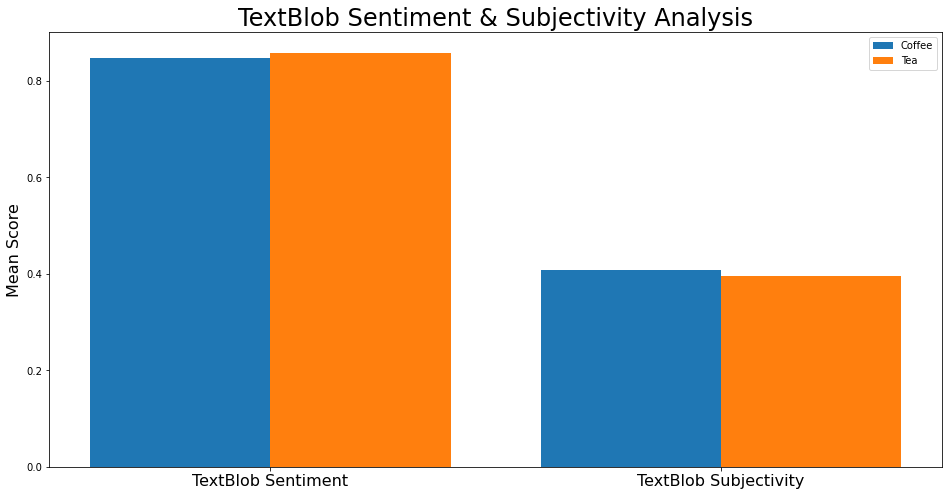

In [10]:
plt.figure(figsize=(16,8))

X = ['TextBlob Sentiment','TextBlob Subjectivity']
Coffee = [coffee_df['sent_pred'].mean(), coffee_df['sub_pred'].mean()]
Tea = [tea_df['sent_pred'].mean(), tea_df['sub_pred'].mean()]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Coffee, 0.4, label = 'Coffee')
plt.bar(X_axis + 0.2, Tea, 0.4, label = 'Tea')
  
plt.xticks(X_axis, X, size = 16)
plt.ylabel("Mean Score", size = 16)
plt.title("TextBlob Sentiment & Subjectivity Analysis", size = 24)
plt.legend()
plt.show();

### Observation

1. The posts under each subreddit fare rather well in general on positivity with posts from tea subreddit performing slightly better. 
2. Though posts of both subreddits have a mean score of about 0.4 for subjectivity, their subjectivity score still leans towards being objective, which provides good basis to use the posts as data for market research.
3. Given the binary nature of sentiment scoring, I will introduce another sentiment analysis tool in order to have a better picture.

## 4. Sentiment Analysis: Pysentimiento

We shall first apply sentiment analysis using [Pysentimiento](https://textblob.readthedocs.io/en/dev/), which is a model from Hugging Face trained on twitter tweets in 2020.

In [11]:
# Initiating the analyzer
sent_analyzer = create_analyzer(task="sentiment", lang="en");

In [12]:
# This code will take awhile to run
coffee_sentiment_list = []
for i in coffee_df['text']:
    coffee_sentiment_list.append(sent_analyzer.predict(i))

In [13]:
# This code will take awhile to run
tea_sentiment_list = []
for i in tea_df['text']:
    tea_sentiment_list.append(sent_analyzer.predict(i))

In [14]:
# Sample input from list
coffee_sentiment_list[0]

AnalyzerOutput(output=NEU, probas={NEU: 0.793, NEG: 0.181, POS: 0.027})

In [15]:
# Coverting to a dataframe
df = pd.DataFrame() 
for i in coffee_sentiment_list:
    coffee_sent = pd.Series({'sentiment': i.output, **i.probas}).to_frame().transpose()
    df = pd.concat([df, coffee_sent])

In [16]:
# Reset index
df.reset_index(inplace=True, drop=True)

In [17]:
# Join data
coffee_df = pd.concat([coffee_df, df], axis=1)

In [18]:
# Doing the same procedures for tea dataset
df1 = pd.DataFrame() 
for i in tea_sentiment_list:
    tea_sent = pd.Series({'sentiment': i.output, **i.probas}).to_frame().transpose()
    df1 = pd.concat([df1, tea_sent])

   sentiment       NEG       NEU       POS
0        POS  0.000864  0.086826  0.912311
0        NEU  0.052485  0.930136  0.017379
0        NEU  0.003486  0.977231  0.019283
0        NEU  0.009748  0.969891  0.020361
0        NEU  0.001586  0.891144   0.10727
..       ...       ...       ...       ...
0        NEU  0.203202  0.706422  0.090376
0        NEU  0.001245  0.711646  0.287109
0        NEU   0.00187  0.922201  0.075929
0        POS  0.000926  0.046913  0.952161
0        POS  0.001672  0.005971  0.992357

[11950 rows x 4 columns]


In [19]:
df1.reset_index(inplace=True, drop=True)

In [20]:
tea_df = pd.concat([tea_df, df1], axis=1)

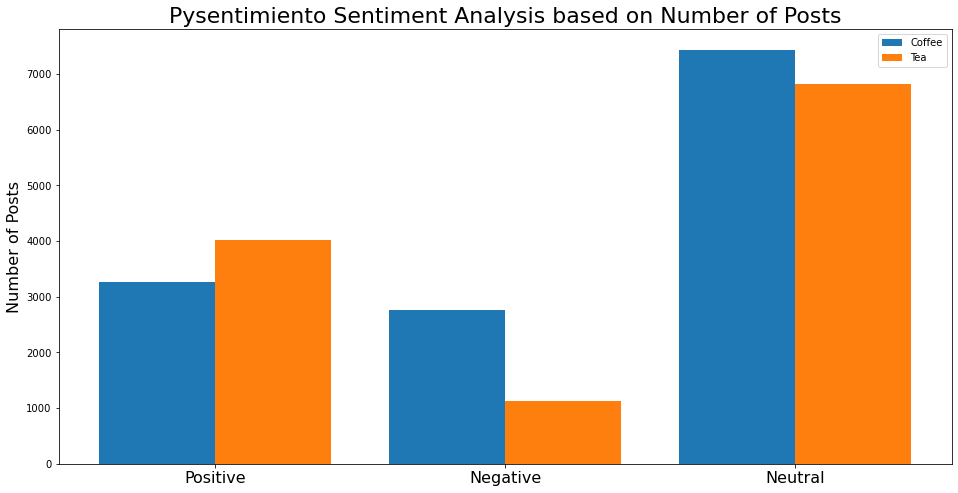

In [21]:
# Graph based on the number of posts
plt.figure(figsize=(16,8))

X = ['Positive','Negative', 'Neutral']
Coffee = [coffee_df['sentiment'].value_counts()[1], coffee_df['sentiment'].value_counts()[2], coffee_df['sentiment'].value_counts()[0]]
Tea = [tea_df['sentiment'].value_counts()[1], tea_df['sentiment'].value_counts()[2], tea_df['sentiment'].value_counts()[0]]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Coffee, 0.4, label = 'Coffee')
plt.bar(X_axis + 0.2, Tea, 0.4, label = 'Tea')
  
plt.xticks(X_axis, X, size = 16)
plt.ylabel("Number of Posts", size = 16)
plt.title("Pysentimiento Sentiment Analysis based on Number of Posts", size = 22)
plt.legend()
plt.show();

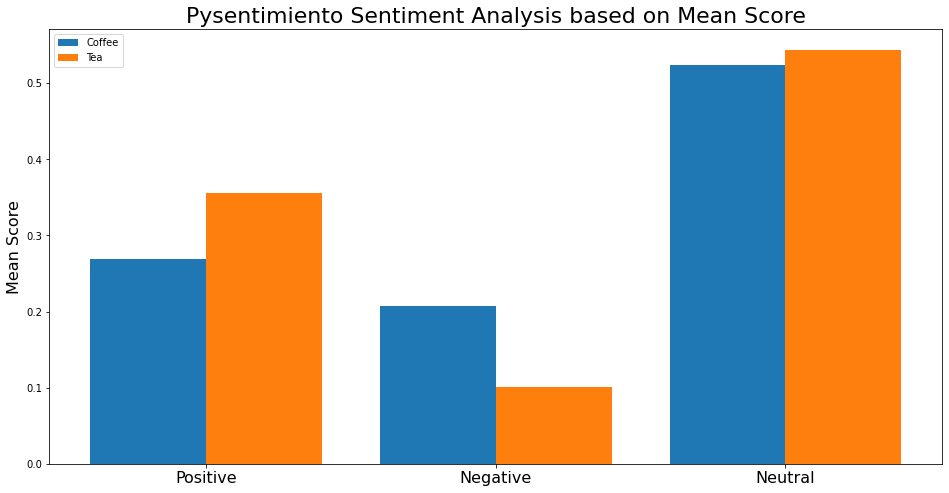

In [22]:
# Graph based on the mean score

plt.figure(figsize=(16,8))

X = ['Positive','Negative', 'Neutral']
Coffee = [coffee_df['POS'].mean(), coffee_df['NEG'].mean(), coffee_df['NEU'].mean()]
Tea = [tea_df['POS'].mean(), tea_df['NEG'].mean(), tea_df['NEU'].mean()]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Coffee, 0.4, label = 'Coffee')
plt.bar(X_axis + 0.2, Tea, 0.4, label = 'Tea')
  
plt.xticks(X_axis, X, size = 16)
plt.ylabel("Mean Score", size = 16)
plt.title("Pysentimiento Sentiment Analysis based on Mean Score", size = 22)
plt.legend()
plt.show();

### Observation

1. Pysentimiento model is able to provide us with a more granular model result by dividing the sentiments into positive, negative and neutral.
2. Most posts belong to the neutral category. Most posts also score higher in being neutral. The neutral scores of tea and coffee subreddits are similar. 
3. Interestingly, posts from tea subreddit scored better in being positive and scored worse in being negative as compared to posts from coffee subreddit.

## 5. Emotion Analysis: Pysentimiento

In [23]:
# Long output
emo_analyzer = create_analyzer(task="emotion", lang="en");

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json from cache at /Users/soonpohchua/.cache/huggingface/transformers/c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others"

In [24]:
# This code will take awhile to run
coffee_emotion_list = []
for i in coffee_df['text']:
    coffee_emotion_list.append(emo_analyzer.predict(i))

In [26]:
# This code will take awhile to run
tea_emotion_list = []
for i in tea_df['text']:
    tea_emotion_list.append(emo_analyzer.predict(i))

In [27]:
# Create a dataframe for coffee
df2 = pd.DataFrame() 
for i in coffee_emotion_list:
    coffee_emo = pd.Series({'sentiment': i.output, **i.probas}).to_frame().transpose()
    df2 = pd.concat([df2, coffee_emo])

In [28]:
# Reset index
df2.reset_index(inplace=True, drop=True)

In [29]:
# Join data
coffee_df = pd.concat([coffee_df, df2], axis=1)

In [30]:
coffee_df.to_csv("coffee_df_cleaned_emo.csv", index = False)

In [31]:
# Same procedures for tea
df3 = pd.DataFrame() 
for i in tea_emotion_list:
    tea_emo = pd.Series({'sentiment': i.output, **i.probas}).to_frame().transpose()
    df3 = pd.concat([df3, tea_emo])

In [32]:
df3.reset_index(inplace=True, drop=True)

In [33]:
tea_df = pd.concat([tea_df, df3], axis=1)

In [34]:
# Renaming columns due to columns with the same name from sentiment and emotion analysis
tea_df.columns = ['subreddit', 'author', 'date_posted', 'text', 'text_cleaned',
       'sent_pred', 'sub_pred', 'sentiment', 'NEG', 'NEU', 'POS', 'emotion',
       'others', 'joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']

In [35]:
coffee_df.columns = ['subreddit', 'author', 'date_posted', 'text', 'text_cleaned',
       'sent_pred', 'sub_pred', 'sentiment', 'NEG', 'NEU', 'POS', 'emotion',
       'others', 'joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']

In [36]:
# Saving a copy of csv as the analysis takes a long time to complete
coffee_df.to_csv("coffee_df_cleaned_emo.csv", index = False)
tea_df.to_csv("tea_df_cleaned_emo.csv", index = False)

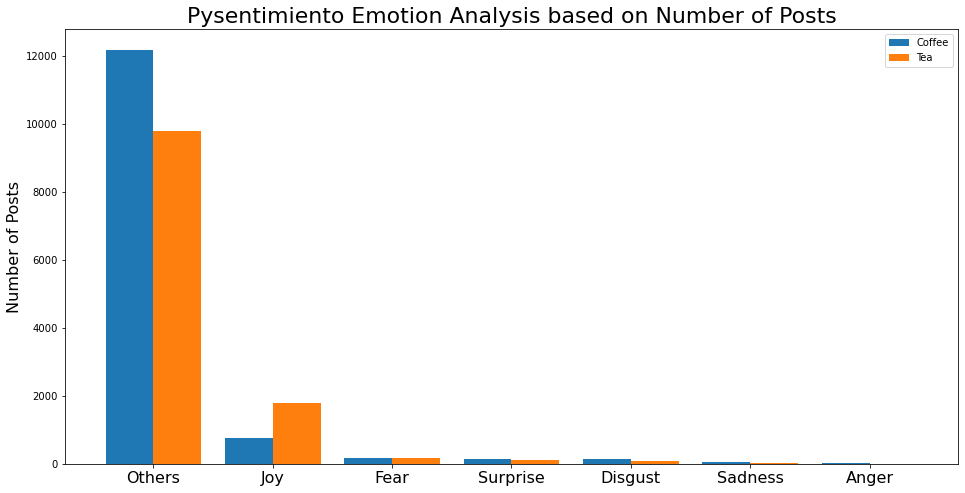

In [37]:
plt.figure(figsize=(16,8))

X = ['Others','Joy', 'Fear', 'Surprise', 'Disgust', 'Sadness', 'Anger']
Coffee = [coffee_df['emotion'].value_counts()[0], coffee_df['emotion'].value_counts()[1], coffee_df['emotion'].value_counts()[2], coffee_df['emotion'].value_counts()[3], coffee_df['emotion'].value_counts()[4], coffee_df['emotion'].value_counts()[5], coffee_df['emotion'].value_counts()[6]]
Tea = [tea_df['emotion'].value_counts()[0], tea_df['emotion'].value_counts()[1], tea_df['emotion'].value_counts()[2], tea_df['emotion'].value_counts()[3], tea_df['emotion'].value_counts()[4], tea_df['emotion'].value_counts()[5], tea_df['emotion'].value_counts()[6]]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Coffee, 0.4, label = 'Coffee')
plt.bar(X_axis + 0.2, Tea, 0.4, label = 'Tea')
  
plt.xticks(X_axis, X, size = 16)
plt.ylabel("Number of Posts", size = 16)
plt.title("Pysentimiento Emotion Analysis based on Number of Posts", size = 22)
plt.legend()
plt.show();

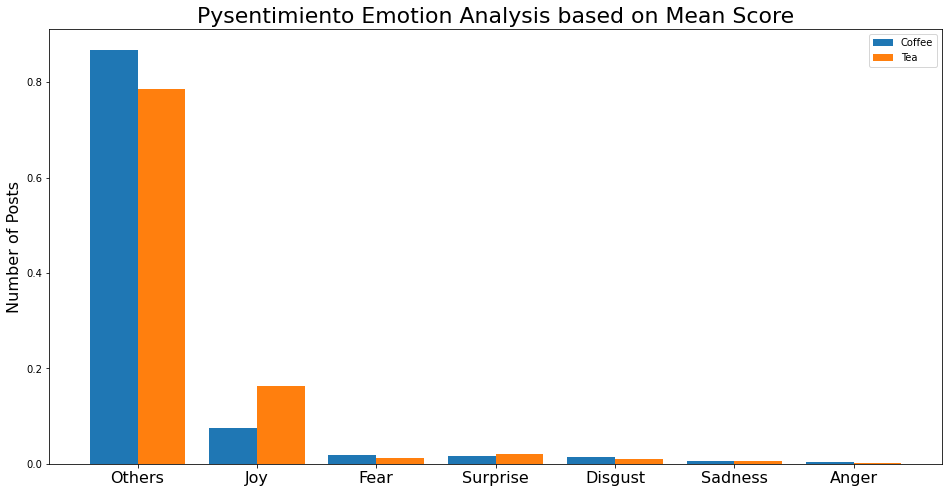

In [38]:
plt.figure(figsize=(16,8))

X = ['Others','Joy', 'Fear', 'Surprise', 'Disgust', 'Sadness', 'Anger']
Coffee = [coffee_df['others'].mean(), coffee_df['joy'].mean(), coffee_df['fear'].mean(), coffee_df['surprise'].mean(), coffee_df['disgust'].mean(), coffee_df['sadness'].mean(), coffee_df['anger'].mean()]
Tea = [tea_df['others'].mean(), tea_df['joy'].mean(), tea_df['fear'].mean(), tea_df['surprise'].mean(), tea_df['disgust'].mean(), tea_df['sadness'].mean(), tea_df['anger'].mean()]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Coffee, 0.4, label = 'Coffee')
plt.bar(X_axis + 0.2, Tea, 0.4, label = 'Tea')
  
plt.xticks(X_axis, X, size = 16)
plt.ylabel("Number of Posts", size = 16)
plt.title("Pysentimiento Emotion Analysis based on Mean Score", size = 22)
plt.legend()
plt.show();

### Observation

1. Similar to the previous sentiment analysis, the result of emotion analysis is that most posts from both subreddit belong to the Others category, which is devoid of the other emotions indicated (much like being neutral). 
2. Posts from both subreddit fare low in emotions such as fear, surprise, disgust, sadness and anger.
3. Interestingly, posts from tea subreddit fare better in terms of joy.

## 6. Analysis based on Popular Topics: Pysentimiento

Referring back to notebook 1, there have been a list of promising topics listed based on the unigram, bigram and trigram analysis of most common words of each subreddit. To recap, below are the list of topics:
 - Promising topics from Coffee subreddit (21 in total): Espresso, Speciality Coffee, Filter Coffee, Dark Roast, Baratza Encore, Burr Grinder, Drip Coffee, Ground Coffee, Moka Pot, French Press, Cold Brew, Timemore Chestnut C2, Breville Barista Pro, Nitro Cold Brew, Fellow Stagg Ekg, 1Zpresso Jx Pro, Aeropress French Press, Breville Smart Grinder, Breville Precision Brewer, Gaggia Classic Pro, Breville Barista Express
 - Promising topics from Tea subreddit (16 in total): Matcha, English Breakfast, Cold Brew, Harney Sons, Oolong Tea, Green Tea, Black Tea, Gong Fu, White Tea, Earl Grey, Da Hong Pao, Tie Guan Yin, Jin Jun Mei, Bi Luo Chun, Jasmine Green Tea, Japanese Green Tea
 
The approach now is to validate each of these topics through sentiment and emotion analysis using the Pysentimiento model. Of interest are indicators which are positive (under sentiment) and joy (under emotion). To assess the importance of the topics, a topic would need to meet the requirement of scoring higher in either positivity or joy as compared to the other posts without the topic. Due to the difference in the number of posts with and without the topic, mean score will be used for comparison.

The project has already picked out those topics from coffee and tea subreddits which fufill the criteria of scoring higher in mean score of either positivity or joy as compared to other posts. Below are the listing and visualisation of these topics.

Note: To differentiate the posts with/without the topics of interest, the 'text_cleaned' column is used for filtering instead of 'text' column (which is the uncleaned version). The 'text_cleaned' column is used for the ease of filtering with the standardisation of words after lemmatization (back in notebook 1). Moreover, the topics were also churned out using the 'text_cleaned' column. Nevertheless, the 'text' column in its original form is used only for analysis as the different variation of words (such as uppercase, emojis etc.) can contribute to both sentiment and emotion analysis.

In [39]:
# Beginning with coffee dataset
# Posts with/without 'nitro cold brew'
coffee_df_nitro = coffee_df[coffee_df['text_cleaned'].str.contains('nitro cold brew', na=False)]
coffee_df_nitro_not = coffee_df[~coffee_df['text_cleaned'].str.contains('nitro cold brew', na=False)]
# Posts with/without 'espresso'
coffee_df_espresso = coffee_df[coffee_df['text_cleaned'].str.contains('espresso', na=False)]
coffee_df_espresso_not = coffee_df[~coffee_df['text_cleaned'].str.contains('espresso', na=False)]
# Posts with/without 'filter coffee'
coffee_df_filter = coffee_df[coffee_df['text_cleaned'].str.contains('filter coffee', na=False)]
coffee_df_filter_not = coffee_df[~coffee_df['text_cleaned'].str.contains('filter coffee', na=False)]
# Posts with/without 'dark roast'
coffee_df_dark = coffee_df[coffee_df['text_cleaned'].str.contains('dark roast', na=False)]
coffee_df_dark_not = coffee_df[~coffee_df['text_cleaned'].str.contains('dark roast', na=False)]
# Posts with/without 'burr grinder'
coffee_df_burr = coffee_df[coffee_df['text_cleaned'].str.contains('burr grinder', na=False)]
coffee_df_burr_not = coffee_df[~coffee_df['text_cleaned'].str.contains('burr grinder', na=False)]
# Posts with/without 'timemore chestnut c2'
coffee_df_timemore = coffee_df[coffee_df['text_cleaned'].str.contains('timemore chestnut c2', na=False)]
coffee_df_timemore_not = coffee_df[~coffee_df['text_cleaned'].str.contains('timemore chestnut c2', na=False)]
# Posts with/without 'breville barista pro'
coffee_df_baristapro = coffee_df[coffee_df['text_cleaned'].str.contains('breville barista pro', na=False)]
coffee_df_baristapro_not = coffee_df[~coffee_df['text_cleaned'].str.contains('breville barista pro', na=False)]
# Posts with/without 'aeropress french press'
coffee_df_aero = coffee_df[coffee_df['text_cleaned'].str.contains('aeropress french press', na=False)]
coffee_df_aero_not = coffee_df[~coffee_df['text_cleaned'].str.contains('aeropress french press', na=False)]
# Posts with/without 'gaggia classic pro'
coffee_df_gaggia = coffee_df[coffee_df['text_cleaned'].str.contains('gaggia classic pro', na=False)]
coffee_df_gaggia_not = coffee_df[~coffee_df['text_cleaned'].str.contains('gaggia classic pro', na=False)]

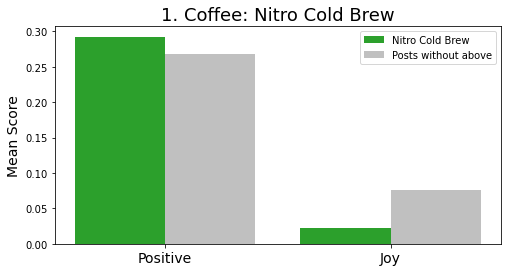

In [40]:
graph_for_sent_emo(coffee_df_nitro,coffee_df_nitro_not,  'Nitro Cold Brew', 'Posts without above', 'Mean Score', '1. Coffee: Nitro Cold Brew')

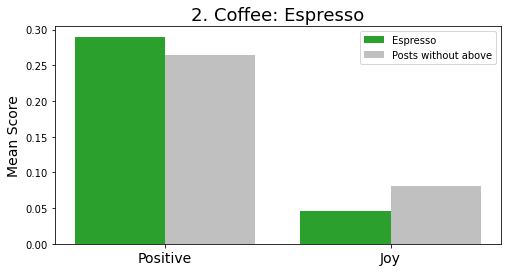

In [41]:
graph_for_sent_emo(coffee_df_espresso,coffee_df_espresso_not,  'Espresso', 'Posts without above', 'Mean Score', '2. Coffee: Espresso')

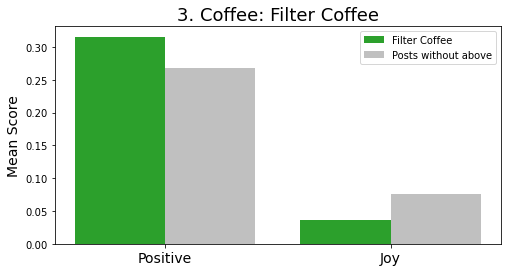

In [42]:
graph_for_sent_emo(coffee_df_filter,coffee_df_filter_not,  'Filter Coffee', 'Posts without above', 'Mean Score', '3. Coffee: Filter Coffee')

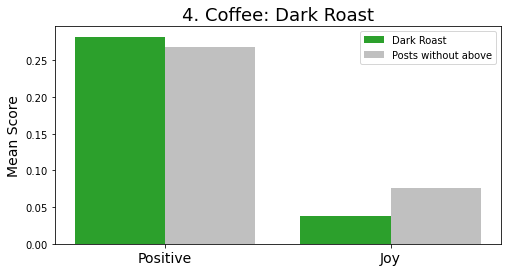

In [43]:
graph_for_sent_emo(coffee_df_dark,coffee_df_dark_not,  'Dark Roast', 'Posts without above', 'Mean Score', '4. Coffee: Dark Roast')

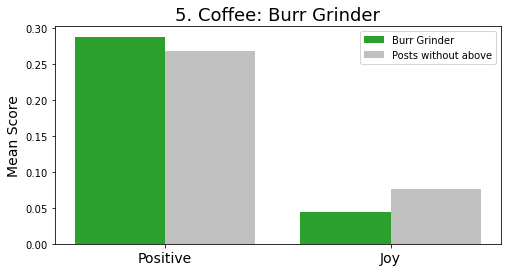

In [44]:
graph_for_sent_emo(coffee_df_burr,coffee_df_burr_not,  'Burr Grinder', 'Posts without above', 'Mean Score', '5. Coffee: Burr Grinder')

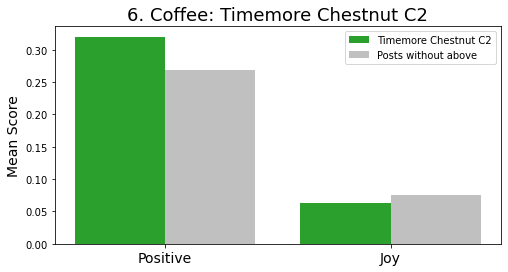

In [45]:
graph_for_sent_emo(coffee_df_timemore,coffee_df_timemore_not,  'Timemore Chestnut C2', 'Posts without above', 'Mean Score', '6. Coffee: Timemore Chestnut C2')

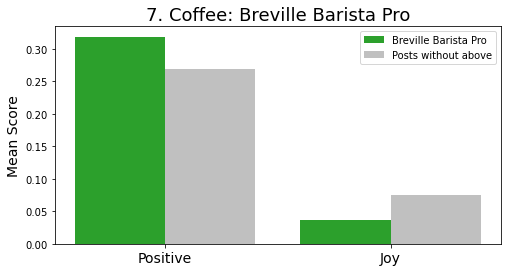

In [46]:
graph_for_sent_emo(coffee_df_baristapro,coffee_df_baristapro_not,  'Breville Barista Pro', 'Posts without above', 'Mean Score', '7. Coffee: Breville Barista Pro')

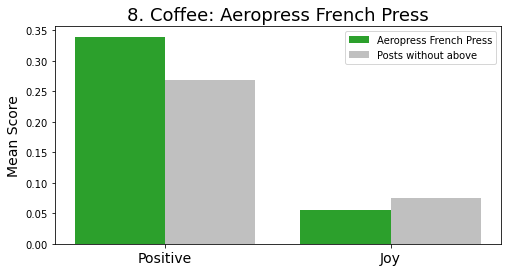

In [47]:
graph_for_sent_emo(coffee_df_aero,coffee_df_aero_not,  'Aeropress French Press', 'Posts without above', 'Mean Score', '8. Coffee: Aeropress French Press')

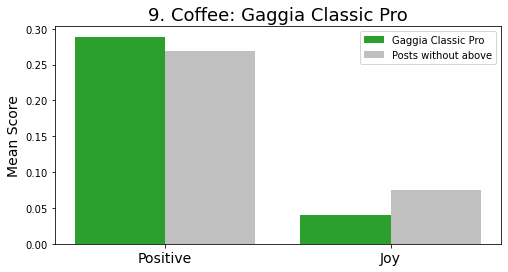

In [48]:
graph_for_sent_emo(coffee_df_gaggia,coffee_df_gaggia_not,  'Gaggia Classic Pro', 'Posts without above', 'Mean Score', '9. Coffee: Gaggia Classic Pro')

In [49]:
# Tea dataset
# Posts with/without 'cold brew'
tea_df_coldbrew = tea_df[tea_df['text_cleaned'].str.contains('cold brew', na=False)]
tea_df_coldbrew_not = tea_df[~tea_df['text_cleaned'].str.contains('cold brew', na=False)]
# Posts with/without 'jin jun mei'
tea_df_jinjunmei = tea_df[tea_df['text_cleaned'].str.contains('jin jun mei', na=False)]
tea_df_jinjunmei_not = tea_df[~tea_df['text_cleaned'].str.contains('jin jun mei', na=False)]
# Posts with/without 'da hong pao'
tea_df_dahongpao = tea_df[tea_df['text_cleaned'].str.contains('da hong pao', na=False)]
tea_df_dahongpao_not = tea_df[~tea_df['text_cleaned'].str.contains('da hong pao', na=False)]
# Posts with/without 'green tea'
tea_df_greentea = tea_df[tea_df['text_cleaned'].str.contains('green tea', na=False)]
tea_df_greentea_not = tea_df[~tea_df['text_cleaned'].str.contains('green tea', na=False)]
# Posts with/without 'earl grey'
tea_df_earlgrey = tea_df[tea_df['text_cleaned'].str.contains('earl grey', na=False)]
tea_df_earlgrey_not = tea_df[~tea_df['text_cleaned'].str.contains('earl grey', na=False)]
# Posts with/without 'japanese green tea'
tea_df_japanese = tea_df[tea_df['text_cleaned'].str.contains('japanese green tea', na=False)]
tea_df_japanese_not = tea_df[~tea_df['text_cleaned'].str.contains('japanese green tea', na=False)]
# Posts with/without 'white tea'
tea_df_white = tea_df[tea_df['text_cleaned'].str.contains('white tea', na=False)]
tea_df_white_not = tea_df[~tea_df['text_cleaned'].str.contains('white tea', na=False)]
# Posts with/without 'black tea'
tea_df_black = tea_df[tea_df['text_cleaned'].str.contains('black tea', na=False)]
tea_df_black_not = tea_df[~tea_df['text_cleaned'].str.contains('black tea', na=False)]
# Posts with/without 'oolong tea'
tea_df_oolong = tea_df[tea_df['text_cleaned'].str.contains('oolong tea', na=False)]
tea_df_oolong_not = tea_df[~tea_df['text_cleaned'].str.contains('oolong tea', na=False)]
# Posts with/without 'harney sons'
tea_df_harney = tea_df[tea_df['text_cleaned'].str.contains('harney sons', na=False)]
tea_df_harney_not = tea_df[~tea_df['text_cleaned'].str.contains('harney sons', na=False)]
# Posts with/without 'english breakfast'
tea_df_english = tea_df[tea_df['text_cleaned'].str.contains('english breakfast', na=False)]
tea_df_english_not = tea_df[~tea_df['text_cleaned'].str.contains('english breakfast', na=False)]

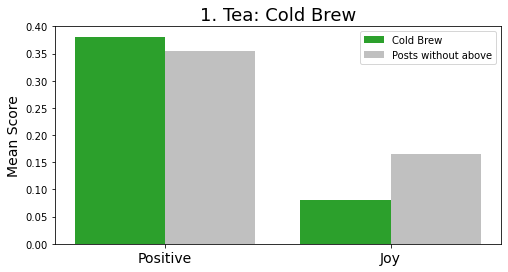

In [50]:
graph_for_sent_emo(tea_df_coldbrew,tea_df_coldbrew_not,  'Cold Brew', 'Posts without above', 'Mean Score', '1. Tea: Cold Brew')

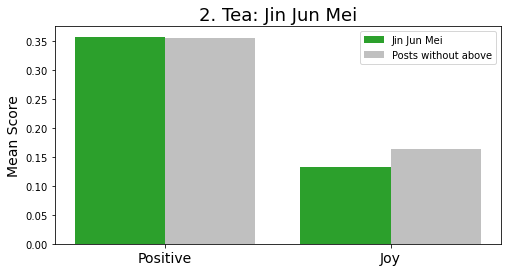

In [51]:
graph_for_sent_emo(tea_df_jinjunmei,tea_df_jinjunmei_not,'Jin Jun Mei', 'Posts without above', 'Mean Score', '2. Tea: Jin Jun Mei')

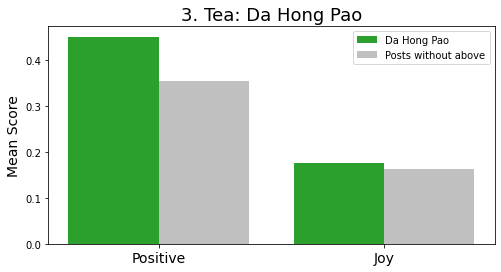

In [52]:
graph_for_sent_emo(tea_df_dahongpao,tea_df_dahongpao_not,'Da Hong Pao', 'Posts without above', 'Mean Score', '3. Tea: Da Hong Pao')

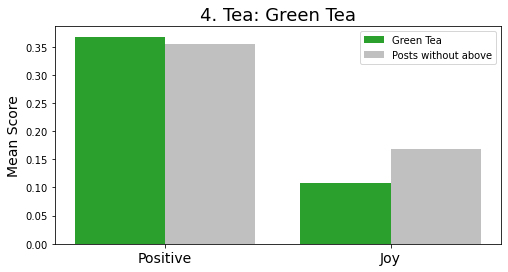

In [53]:
graph_for_sent_emo(tea_df_greentea,tea_df_greentea_not,'Green Tea', 'Posts without above', 'Mean Score', '4. Tea: Green Tea')

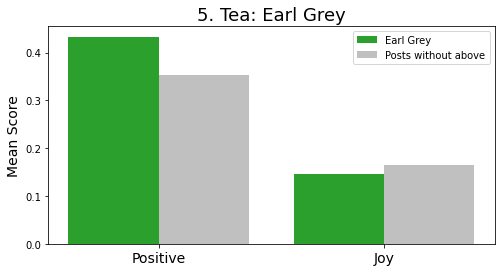

In [54]:
graph_for_sent_emo(tea_df_earlgrey,tea_df_earlgrey_not,'Earl Grey', 'Posts without above', 'Mean Score', '5. Tea: Earl Grey')

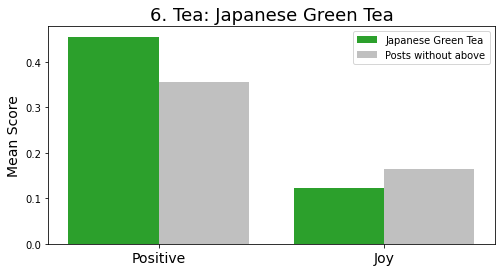

In [55]:
graph_for_sent_emo(tea_df_japanese,tea_df_japanese_not,'Japanese Green Tea', 'Posts without above', 'Mean Score', '6. Tea: Japanese Green Tea')

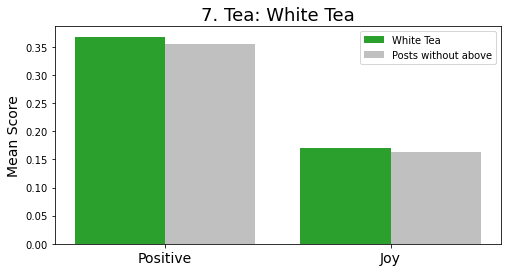

In [56]:
graph_for_sent_emo(tea_df_white,tea_df_white_not,'White Tea', 'Posts without above', 'Mean Score', '7. Tea: White Tea')

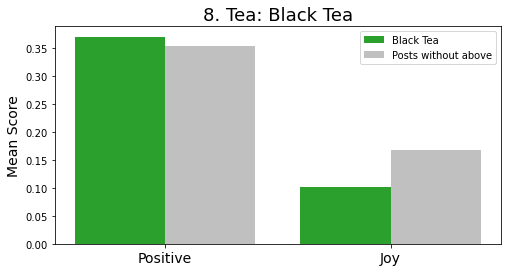

In [57]:
graph_for_sent_emo(tea_df_black,tea_df_black_not,'Black Tea', 'Posts without above', 'Mean Score', '8. Tea: Black Tea')

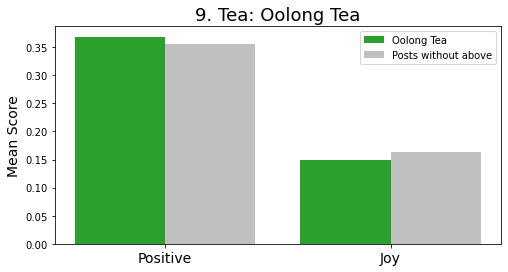

In [58]:
graph_for_sent_emo(tea_df_oolong,tea_df_oolong_not,'Oolong Tea', 'Posts without above', 'Mean Score', '9. Tea: Oolong Tea')

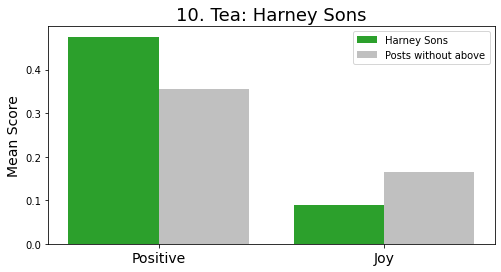

In [59]:
graph_for_sent_emo(tea_df_harney,tea_df_harney_not,'Harney Sons', 'Posts without above', 'Mean Score', '10. Tea: Harney Sons')

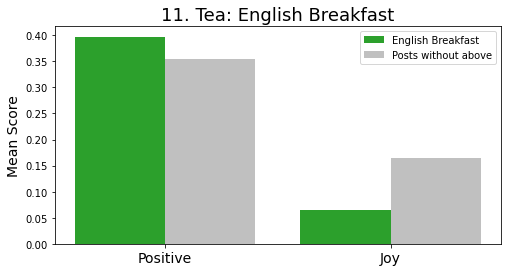

In [60]:
graph_for_sent_emo(tea_df_english,tea_df_english_not,'English Breakfast', 'Posts without above', 'Mean Score', '11. Tea: English Breakfast')

### Observation

1. Of the 21 promising topics from the Coffee subreddit, only 9 passed the criteria of having higher mean score in either positivity or joy. All of the 9 topics were only able to fulfil a higher positivity score than posts without the topic. The topics are: nitro cold brew, espresso, filter coffee, dark roast, burr grinder, timemore chestnut c2, breville barista pro, aeropress french press (technically two topics) and gaggia classic pro.
2. Of the 16 promising topics from the Tea subreddit, 11 passed the criteria. All were able to fulfil a higher positivity score than posts without the topic. The topics 'White Tea' and 'Da Hong Pao' performed the best as they were also able to fulfill having a higher mean score on joy than the other posts. The topics are: cold brew, jin jun mei, da hong pao, green tea, earl grey, japanese green tea, white tea, black tea, oolong tea, harney sons and english breakfast.
3. Taken together, they can potentially influence the cafe in the following areas:
    - Choice of Beverages: espresso, jin jun mei, da hong pao, green tea, earl grey, japanese green tea, white tea, black tea, oolong tea, english breakfast
    - Method of Coffee/Tea-Making: nitro cold brew, filter coffee, dark roast, aeropress, french press, cold brew tea
    - Coffee/Tea-Making Products: burr grinder, timemore chestnut c2, breville barista pro, gaggia classic pro, harney and sons

## 7. Summary of Notebook 3

Below is a summary of the main findings covered in this notebook :-

**1. General Sentiment/ Emotion Analysis**
   - Textblob Sentiment Analysis:
       - Posts under each subreddit fare well on positivity more than 0.8 out of 1
       - Posts under each subreddit leans towards being objective than subjective
   - Pysentimiento Sentiment Analysis:
       - Most posts belong to the neutral category and score higher in being neutral
       - Posts from tea subreddit scored better in being positive and scored worse in being negative as compared to posts from coffee subreddit.
   - Pysentimiento Emotion Analysis:
       - Most posts from both subreddit belong to the Others category, which is devoid of the other emotions indicated (much like being neutral).
       - Posts from both subreddits fare low in emotions such as fear, surprise, disgust, sadness and anger.
       - Posts from tea subreddit fare better in terms of joy.


**2. Analysis on Popular Topics**
   - Promising topics were listed back in notebook 1. There are 21 topics and 16 topics for Coffee and Tea subreddits respectively.  
   - Of interest are indicators which are positive (under sentiment) and joy (under emotion).
   - Topic would need to meet the requirement of scoring higher in either positivity or joy as compared to the other posts without the topic.
   - Of the 21 promising topics from the Coffee subreddit, only 9 passed the criteria of having higher mean score in either positivity or joy. All of the 9 topics were only able to fulfil a higher positivity score than posts without the topic. The topics are: nitro cold brew, espresso, filter coffee, dark roast, burr grinder, timemore chestnut c2, breville barista pro, aeropress french press and gaggia classic pro.
   - Of the 16 promising topics from the Tea subreddit, 11 passed the criteria. All were able to fulfil a higher positivity score than posts without the topic. The topics 'White Tea' and 'Da Hong Pao' performed the best as they were also able to fulfill having a higher mean score on joy than the other posts.
   - Taken together, they can potentially influence the cafe in the following areas:
        - Choice of Beverages: espresso, jin jun mei, da hong pao, green tea, earl grey, japanese green tea, white tea, black tea, oolong tea, english breakfast
        - Method of Coffee/Tea-Making: nitro cold brew, filter coffee, dark roast, aeropress, french press, cold brew tea
        - Products related to Coffee/Tea: burr grinder, timemore chestnut c2, breville barista pro, gaggia classic pro, harney and sons

## 8. Conclusion

### 8.1 Possible Areas for Improvement

What the project has established thus far is solely based data scraped from the coffee and tea subreddit threads for classification of coffee/tea topics and to generate useful and helpful topics based on sentiment/ emotion analysis. The following can be considered for areas of improvement:-

1. **Increase the amount of data**
     - Increase the number of posts scrapped from each subreddit (current project only scrapped 15000 posts)
     - Expand the scope of datascrapping to other subreddits with relevant topics such as coffee-making machine or tea brewing etc.
     - Explore other similar platforms like twitter or facebook to scrape additional data

2. **Include related topics in a cafe set-up setting**
    - In addition to point 1, there could be other topics such as cake in a cafe set-up setting apart from coffee and tea

3. **Further testing on sentiment analysis**
    - We can consider using another model as comparison
    - Ideally, result of sentiment analysis can be more accurate by using human annotation

### 8.2 Limitation

The project has the following limitations:-
1. Data is only extracted from the Reddit platform, which lacks diversity;
2. Based on [market research](https://backlinko.com/reddit-users), close to 50% of the Reddit users are based in United States, which cannot be generalised for the global market; and 
3. Despite picking out the most common words using unigram, bigramm and trigram analysis, the posts containing noteworthy topics are little as compared to the those posts without. Nevertheless, the project tried to sidestep the issue by using mean score. 
4. The project did not demojize emoticons prior to sentiment analysis. The mistake was identified upon presentation. I will rectify this post-project submission. 

Nevertheless, despite the limitations, the project does serve as a helpful baseline for further exploration as recommended under possible areas for improvement.

### 8.3 Summary

In summary, this project wants to accomplish two things:-

1. Produce a classification model to classify texts according to either coffee or tea topic; and
2. Provide sentiment analysis on each subreddit in general and specific topics of interest under each subreddit.


After hyperparameter tuning, the best model was found to be logistic regression with training and test scores of 0.869 and 0.871 respectively. Moving forward, the hope is to utilise the model for further classfication tasks when gathering feedback and further analysis across other platforms. Nevertheless, a diversity of data from different sources would be necessarily to improve on the model for various context. 

As for sentiment analysis, Pysentimiento model was heavily utilised. The key findings were the noteworthy topics which perform better than the posts without them in the area of postivity and joy. Combining the findings across both datasets, the following topics are worth further exploration for cafe set-up business decisions:-
   - Choice of Beverages: espresso, jin jun mei, da hong pao, green tea, earl grey, japanese green tea, white tea, black tea, oolong tea, english breakfast
   - Method of Coffee/Tea-Making: nitro cold brew, filter coffee, dark roast, aeropress, french press, cold brew tea
   - Products related to Coffee/Tea: burr grinder, timemore chestnut c2, breville barista pro, gaggia classic pro, harney and sons